In [15]:
import pandas as pd
import re
import regex as rx
from tabulate import tabulate
from IPython.display import display, HTML

In [16]:
data = pd.read_csv('C:/Users/dominik/Desktop/Uni/Masterthesis/Data/Outputs/Scrape/220705_html_content.csv', sep='\t')

In [17]:
data = data[~data["links"].str.contains("cloudflare", na = False)]

In [18]:
data = data.dropna()
data = data.drop_duplicates(subset=['html_content'], keep="first")

In [19]:
# get only subset of data - less than x websites

## shorten links in order to only represent start of link
data["shortened"] = data["links"].str.replace("https://www.","")
data["shortened"] = data["shortened"].str.replace("https://app.","")
data["shortened"] = data["shortened"].str.replace("https://","")

## split links into multiple parts and get project links - only first part of split represents middle part of link
data["project_website"] = data["shortened"].map(lambda x: re.split(r"\.", x)[0])

## drop unnecessary columns  
data = data.drop(data.columns[[0,3]],axis =1)
 
## count appearence of websites in corpus
data_summary = data.groupby(['project_website'])['project_website'].count()
data_summary = pd.DataFrame(data_summary)
data_summary.rename(columns = {"project_website": "count"},inplace = True)
data_summary.reset_index(inplace=True)

C:\Users\dominik\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
C:\Users\dominik\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


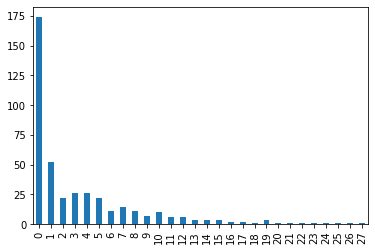

In [20]:
## count the appearences of subsites of projects
plot_summary = data_summary.groupby(['count'])['count'].count()
## create dataframe
plot_summary = pd.DataFrame(plot_summary)

## rename columns and replace index
plot_summary.rename(columns = {"count": "count_agg"},inplace = True)
plot_summary.reset_index(inplace=True)
plot_summary.rename(columns = {"count": "count_websites"},inplace = True)

## plot aggregated data
plot_summary["count_agg"].plot(kind = "bar")

## decide cutoff point to decide how many websites should be represented
plot_summary["Readjust"] = plot_summary["count_websites"] > 15

In [22]:
plot_summary.to_csv("C:/Users/dominik/Desktop/Uni/Masterthesis/Data/Outputs/Scrape/plot_summary.csv")

In [6]:
## create dictionary to map cutoff point
readjust_dict = dict(zip(plot_summary.count_websites, plot_summary.Readjust))

## map cutoff point to data summary
data_summary["readjust"] = data_summary["count"].map(readjust_dict)

## create dictionary to map cutoff point on data
pro_rea = dict(zip(data_summary.project_website,data_summary.readjust))

## map cutoff point to data
data["readjust"] = data["project_website"].map(pro_rea)

# count words
data["word_count"] = data["html_content"].str.split().str.len()

## filter for project_website where more than 15 websites were scraped and separate dataset into two parts
data_no_strip = data[data["readjust"] == False]
data_no_strip = data_no_strip.drop(["readjust"],axis = 1)
data_sub = data[data["readjust"] == True]
data_sub = data_sub.drop(["readjust"],axis = 1)
data_sub = data_sub.sort_values(['project_website','word_count'],ascending=False)

## applying rank in order to only filter out with fewest words
#data_sub["rank"] = data_sub[["project_website","word_count"]].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)
data_sub["rank"] = data_sub.groupby("project_website")["word_count"].rank("dense", ascending=False)

## filter out all websites after 15 and prepare dataset for aggregation with other websites
data_strip = data_sub[data_sub["rank"]<=15]

## aggregate data together
data_normalized = data_no_strip.append(data_strip, ignore_index = True)
data_normalized = data_normalized.drop(data_strip.columns[[2,4]],axis =1)

In [7]:
data_normalized

,links,html_content,word_count
0,https://boredapeyachtclub.com/#/mayc/home#team,BUY AN APE\nROADMAP\nTEAM\nGALLERY\nPROVENANCE...,588
1,https://boredapeyachtclub.com/#/provenance,BUY AN APE\nROADMAP\nTEAM\nGALLERY\nPROVENANCE...,70181
2,https://boredapeyachtclub.com/#/mayc/terms,BUY AN APE\nROADMAP\nTEAM\nGALLERY\nPROVENANCE...,2451
3,https://boredapeyachtclub.com/#,WELCOME TO\nTHE BORED APE\nYACHT CLUB\nENTER\n...,55
4,https://boredapeyachtclub.com/#/home#roadmap,BUY AN APE\nROADMAP\nTEAM\nGALLERY\nPROVENANCE...,676
...,...,...,...
1726,https://www.coolcatsnft.com/charity,CONNECT\nCool Cats Charity\nA core value of th...,184
1727,https://www.coolcatsnft.com/pet-checker,CONNECT\nPet Checker\nUse the pet checker belo...,139
1728,https://www.coolcatsnft.com/team,CONNECT\nThe Team\nSay hello to the Cool Cats ...,133
1729,https://www.coolcatsnft.com/leaderboard/quests...,CONNECT\nQUESTS COMPLETED\nBACK\n1ST\n0x1ce......,108


In [8]:
# calculate quantity of not normalized websites
quantity_websites = len(data)

# calculate word quantity of not normalized websites 
words_data = data["word_count"].sum()

# calculate quantity of normalized websites
quantity_websites_normalized = len(data_normalized)

# calculate word quantity of normalized websites 
words_data_normalized = data_normalized["word_count"].sum()

# calculate word difference between not normalized and normalized data
word_difference = words_data - words_data_normalized

In [9]:
# tabelize data to display in thesis
table_data = {"Words Dataset":[words_data],
              "Words Normalized Dataset":[words_data_normalized],
              "Words Removed from Data":[word_difference],
              "Quantity of unique websites in Dataset":[quantity_websites],
              "Quantity of unique websites in Normalized Dataset":[quantity_websites_normalized]}
table_inf = pd.DataFrame(table_data)

In [10]:
table_inf_transposed = table_inf.T
table_inf_transposed.rename(columns = {0:"count"},inplace = True)

In [11]:
table_inf_transposed.loc[:, "count_thousands"] = table_inf_transposed["count"].map('{:,}'.format)

In [12]:
print(table_inf_transposed.to_latex(index=True))  

\begin{tabular}{lrl}
\toprule
{} &    count & count\_thousands \\
\midrule
Words Dataset                                     &  1121145 &       1,121,145 \\
Words Normalized Dataset                          &  1105325 &       1,105,325 \\
Words Removed from Data                           &    15820 &          15,820 \\
Quantity of unique websites in Dataset            &     1917 &           1,917 \\
Quantity of unique websites in Normalized Dataset &     1731 &           1,731 \\
\bottomrule
\end{tabular}



In [13]:
data_normalized.to_csv('C:/Users/dominik/Desktop/Uni/Masterthesis/Data/Outputs/Scrape/220705_html_content_normalized.csv',index=False)